[View in Colaboratory](https://colab.research.google.com/github/OliStiel/BiasFactors2018/blob/master/Datathon_Project_Interventions_by_Bias_Factors.ipynb)

Copyright 2018 Google Inc.

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

> https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [0]:
# Import libraries
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path
from matplotlib.gridspec import GridSpec
# from sklearn.preprocessing import PolynomialFeatures

# Below imports are used to print out pretty pandas dataframes
from IPython.display import display, HTML

# Imports for accessing Datathon data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [0]:
auth.authenticate_user()

In [0]:
project_id='london-datathon'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

In [0]:
# Read data from BigQuery into pandas dataframes.
def run_query(query):
  return pd.io.gbq.read_gbq(query, project_id=project_id, verbose=False, configuration={'query':{'useLegacySql': False}})

## Analysis

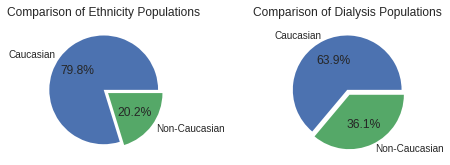

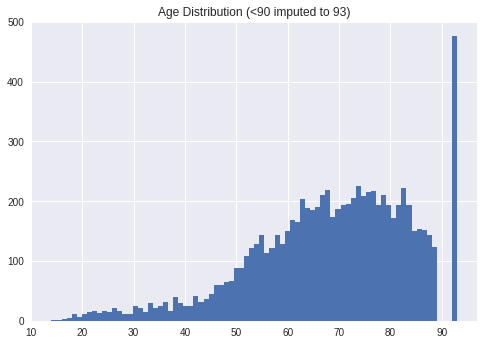

In [219]:
df = run_query('''
SELECT
  pati.patientunitstayid,
  pati.gender,
  CASE WHEN pati.age = '> 89' THEN '93' ELSE pati.age END as Age,
  CASE WHEN pati.ethnicity != 'Caucasian' 
    THEN 'Non-Caucasian'
    ELSE 'Caucasian' END as Ethnicity,
  resu.apachescore,
  CASE WHEN IFNULL(diag.icd9code,'0') = '0' THEN 0 ELSE 1 END as ESRD,
  dial.dialysis,
  resu.ActualVentdays,
  hosp.teachingstatus,
  hosp.hospitalid,
  hosp.numbedscategory,
  hosp.region,
  pati.hospitaldischargeoffset/60/24 as dischargetimedays,
  pati.hospitalAdmitOffset/60/24 as hospitalAdmitOffset ,
  (pati.hospitaldischargeoffset - pati.hospitalAdmitOffset)/60/24 as hospitalFullDuration
FROM
  `physionet-data.eicu.patient` pati
JOIN
  `physionet-data.eicu.hospital` hosp ON hosp.hospitalid = pati.hospitalid
JOIN
  `physionet-data.eicu.apachepatientresult` resu ON resu.patientunitstayid = pati.patientunitstayid
JOIN
  `physionet-data.eicu.apacheapsvar` dial ON dial.patientunitstayid = pati.patientunitstayid
LEFT JOIN 
  `physionet-data.eicu.diagnosis` diag ON diag.patientunitstayid = pati.patientunitstayid 
AND 
  diag.icd9code like '%585.6%'
WHERE
  unitdischargelocation = 'Death'
AND
  pati.ethnicity in ('Caucasian','African American','Other/Unknown','Native American','Hispanic', 'Asian')
-- AND 
--  ActualVentdays < (pati.hospitaldischargeoffset/60/24)+2
GROUP BY patientunitstayid,age,gender,   CASE WHEN pati.ethnicity != 'Caucasian' 
    THEN 'Non-Caucasian'
    ELSE 'Caucasian' END, dialysis, apachescore, region,
    ActualVentdays, teachingstatus, 
    hospitalid,numbedscategory,pati.hospitaldischargeoffset/60/24,
    pati.hospitalAdmitOffset/60/24,icd9code,
    (pati.hospitaldischargeoffset - pati.hospitalAdmitOffset)/60/24;

''')

df.columns = ['Unit_Stay_ID','Gender','Age', 'Ethnicity','Apache_Score','ESRD',
              'Dialysis','Actual_Vent_Days','Teaching_Status','Hospital_ID',
              'Bed_Category','Hospital_Region','Discharge_Time_Days',
              'Hospital_Admit_Offset','Hospital_Full_Duration']

df['Age'] = pd.to_numeric(df['Age'])
df['Actual_Vent_Days'] = pd.to_numeric(df['Actual_Vent_Days'])
df['Actual_Vent_Days'] = df['Actual_Vent_Days'].fillna(0)
df['Vent_Status'] = np.where(df['Actual_Vent_Days']>0, 1, 0)


df.drop('Unit_Stay_ID', axis=1, inplace=True)
df = df.loc[df['ESRD'] == 0]
# poly = PolynomialFeatures(2, interaction_only=True)
# polyframe = pd.DataFrame(poly.fit_transform(df[['Age','Apache_Score']]))

# df = pd.concat([df,polyframe],axis=1)

races = ['Caucasian','Non-Caucasian']
genders = ['Female', 'Male']

dfsize = len(df)

ethnicitySizes = [len(df.loc[df['Ethnicity'] == x]) for x in races]
dialysisSizes = [len(df.loc[(df['Dialysis'] == 1) & (df['Ethnicity'] == x)]) for x in races]


the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1)
plt.gca().set_title('Comparison of Ethnicity Populations')
plt.pie(ethnicitySizes, labels = races, explode=(0,0.1), autopct='%1.1f%%')
plt.subplot(the_grid[0, 1], aspect=1)
plt.pie(dialysisSizes, labels = races, explode=(0,0.1), autopct='%1.1f%%')
plt.gca().set_title('Comparison of Dialysis Populations')

plt.show()
  
# for i in genders:
#  genderVol = len(df.loc[df['Gender'] == i])
#  dialysisVol = len(df.loc[(df['Dialysis'] == 1) & (df['Gender'] == i)])
#  totaldialysisVol = len(df.loc[(df['Dialysis'] == 1)])
  
#  plt.subplot(211)
#  plt.bar(x=i, height=float(genderVol)/float(dfsize)*100)
#  plt.subplot(212)
#  plt.bar(x=i, height=float(dialysisVol)/float(totaldialysisVol)*100)  
  
# plt.show()

# Distribution of Ages (93 being the outlier)
plt.figure()
plt.hist(df['Age'], bins=80)
plt.gca().set_title('Age Distribution (<90 imputed to 93)')

plt.show()

Moving onto Bed Capacities - impact of bed capacity on dialysis volumes

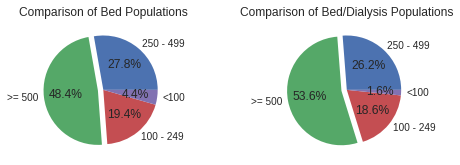

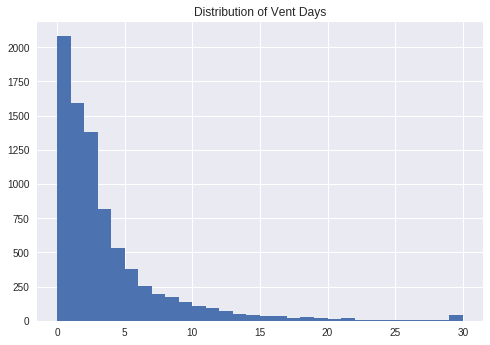

In [220]:
bed_capacities = ['250 - 499', '>= 500', '100 - 249', '<100']

bedVolume = [len(df.loc[df['Bed_Category'] == x]) for x in bed_capacities]
bedDialysisVolume = [len(df.loc[(df['Dialysis'] == 1) & (df['Bed_Category'] == x)]) for x in bed_capacities]

the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1)
plt.gca().set_title('Comparison of Bed Populations')
plt.pie(bedVolume, labels = bed_capacities, explode=(0,0.1,0,0), autopct='%1.1f%%')
plt.subplot(the_grid[0, 1], aspect=1)
plt.pie(bedDialysisVolume, labels = bed_capacities, explode=(0,0.1,0,0), autopct='%1.1f%%')
plt.gca().set_title('Comparison of Bed/Dialysis Populations')

plt.show()

plt.hist(x=df['Actual_Vent_Days'],bins=30)
plt.gca().set_title('Distribution of Vent Days')

plt.show()


[1538, 2755, 1059, 174]


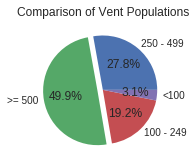

In [221]:
bed_capacities = ['250 - 499', '>= 500', '100 - 249', '<100']

ventVolume = [len(df.loc[(df['Vent_Status'] == 1) & (df['Bed_Category'] == x)]) for x in bed_capacities]

the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 0], aspect=1)
plt.gca().set_title('Comparison of Vent Populations')
plt.pie(ventVolume, labels = bed_capacities, explode=(0,0.1,0,0), autopct='%1.1f%%')

print(ventVolume)
plt.show()

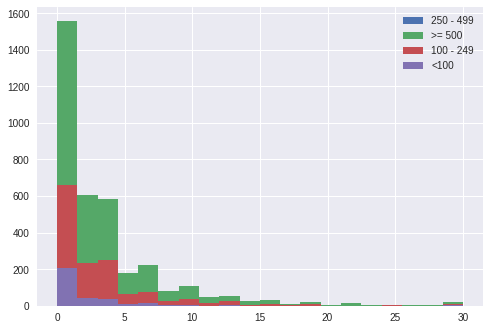

In [222]:
ax = plt.axes()

for k in bed_capacities:
  ax.hist(df['Actual_Vent_Days'].loc[df['Bed_Category'] == k], bins=20, label='Test')

ax.legend([x for x in bed_capacities])

plt.show()  

In [0]:
df['Ethnicity'], ethMap = pd.factorize(df['Ethnicity'])
df['Teaching_Status'], teachMap = pd.factorize(df['Teaching_Status'])
df['Bed_Category'], bedMap = pd.factorize(df['Bed_Category'])
df['Hospital_ID'], hospMap = pd.factorize(df['Hospital_ID'])
df['Gender'], genMap = pd.factorize(df['Gender'])
df['Hospital_Region'], hospMap = pd.factorize(df['Hospital_Region'])

Attempting to model the duration of ventilation days, and attempting to model whether or not the patient was ventilated at all. The former went very poorly, with high errors when attempting to regress. The latter has gone slightly better, but still poorly

[('Gender', 0.26508759119960473), ('Age', 0.15294961605964855), ('Ethnicity', 0.015994903555494856), ('Teaching_Status', 0.026458451891967195), ('Bed_Category', 0.06583336829058538), ('Hospital_Region', 0.47367606900269926)]


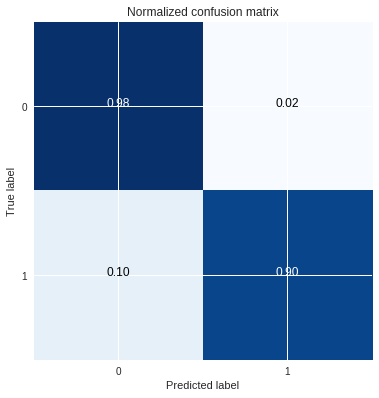

In [226]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Lasso, HuberRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
        # print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

params = {'n_estimators': 300}

# regr = GradientBoostingRegressor(**params)
# regr = RandomForestRegressor(**params)
regr = RandomForestClassifier(**params)
# regr = HuberRegressor()

df0 = df[:500].loc[df['Dialysis'] == 0]
df1 = df.loc[df['Dialysis'] == 1]

dfx = pd.concat([df0,df1])

#dfx = df.loc[(df['Apache_Score'] >= 20) & (df['Apache_Score'] <= 40)]

X = dfx.drop(['Actual_Vent_Days','Hospital_Admit_Offset', 'Discharge_Time_Days',
             'Hospital_Full_Duration','Hospital_ID','Apache_Score','Vent_Status','Dialysis', 'ESRD'], axis=1)

y = dfx['Dialysis']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.45)
regr.fit(X_train, y_train)
preds = regr.predict(X_test)

cnf_matrix = confusion_matrix(y_test, preds)

plot_confusion_matrix(cnf_matrix, classes=[0,1], normalize=True,
                      title='Normalized confusion matrix')

print([x for x in (zip(X_train.columns, regr.feature_importances_))])




In [228]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()

test = enc.fit_transform(df['Hospital_Region'])

print(test)

ValueError: ignored